# Qiskit Nature

Qiskit Nature is the application module dealing with problems in **natural sciences**.
Its goal is to provide end-user oriented modules which enable the fast solution of problems in _chemistry_, _physics_ and _biology_.

Chemistry problems are of particular interest because they are a natural simulation target for quantum computing.

<div style="float: left; width: 50%;">
    <br/>
    <br/>
    <i>If you have 125 orbitals and you want to store all possible configurations, then you need more memory in your classical computer than there are atoms in the universe.</i>
    <br/>
    <br/>
    Matthias Troyer
    
</div>

<div style="float: right; width: 50%; padding-right=20px;">
    <img src="images/intro.png" width="600"/>
    <br>
</div>

Nature currently provides the following modules:

<img src="images/overview.png" width="1400"/>

In general, any application is split into **Problems** and **Solvers** which are combined like so:
<img src="images/Nature_YT_Workflow.svg"/>
> or in terms of code: `result = solver.solve(problem)`

This modular approach permits the reusability of a solver for multiple problems.

Depending on your actual application, the internals of your problem can take different forms.
For example, the `ElectronicStructureProblem` (which we will be discussing today) looks like this:
<img src="images/Nature_YT_ElectronicStructureProblem.svg"/>

A similar modularity exists for the solvers. Generally these are provided by the `qiskit_nature.algorihtms` module which provide convenient wrappers of the actual algorithms implement in Qiskit Terra.
Here is an example of the `GroundStateEigensolver` which we will be looking at today:
<img src="images/Nature_YT_GroundStateEigensolver.svg"/>

## Electronic Structure

Let us now dive into the `ElectronicStructureProblem`. First, to cover some basics, let us talk about the general electronic Hamiltonian,

<img src="images/hamiltonian.png" width="1300"/>

Here, we made use of the _Born-Oppenheimer approximation_, which allows us to separate the motion of the electrons from that of the much heavier nuclei.

Finally, the format expression of our problem is given by the _non-relativistic time-independent Schrödinger equation_:

$$
\hat{H} |\Psi_{n}\rangle = E_{n} |\Psi_{n}\rangle,
$$

whose ground state energy is given by:
$$
E_0 = \frac{\langle \Psi_0 | \hat{H} | \Psi_0 \rangle}{\langle \Psi_0 | \Psi_0 \rangle}
$$
where $\Psi_0$ is the ground state of the system.

### Second Quantization

Up until now we have used the so-called _first quantization_ notation. However, in Qiskit we more commonly express our problems in the _second quantization_ form.
This notation allows us to write our Hamiltonian as a weighted sum of **creation** and **annihilation** operator products.

Our Hamiltonian takes the form:

$$
\hat{H}=\sum_{pq} h_{pq} \hat{a}^{\dagger}_p \hat{a}_q + 
\frac{1}{2} \sum_{pqrs} g_{pqrs}  \hat{a}^{\dagger}_p \hat{a}^{\dagger}_q \hat{a}_r  \hat{a}_s
$$
with the 1-body integrals
$$
h_{pq} = \int \phi^*_p(r) \left( -\frac{1}{2} \nabla^2 - \sum_{I} \frac{Z_I}{R_I- r} \right)   \phi_q(r)dr
$$
and 2-body integrals
$$
g_{pqrs} = \int \frac{\phi^*_p(r_1)  \phi^*_q(r_2) \phi_r(r_2)  \phi_s(r_1)}{|r_1-r_2|}dr_1dr_2.
$$

The beauty of the second quantization formalism is that not only operators but also **states** are written using the _creation_ and _annihilation_ operators.

<div style="float: left; width: 50%;">
    Effectively, this means that our system's wave function can be represented as an <b>occupation number vector</b>.
    This enables a very straight forward notation of <i>ground</i> and <i>excited states</i>:
</div>

<div style="float: right; width: 50%; padding-right=20px;">
    <img src="images/onv.png" width="600"/>
    <br>
</div>

### The `ElectronicStructureProblem`

In [1]:
import warnings
from h5py.h5py_warnings import H5pyDeprecationWarning
warnings.filterwarnings(action="ignore", category=H5pyDeprecationWarning)

In [2]:
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureMoleculeDriver, ElectronicStructureDriverType
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer

FermionicOp.set_truncation(500)

The `ElectronicStructureProblem` makes it easy for us to represent a problem of the form which we just discussed.
As an input, this kind of problem takes a so called `Driver` which is a concept in Qiskit Nature that allows us to couple to other (classical) computational chemistry codes which compute the 1- and 2-body integrals ($h_{pq}$ and $g_{pqrs}$) for us.

As a simple example, we will be using the generic `Molecule`-based interface and tell it to use `PySCF` as the classical computational backend.

In [3]:
molecule = Molecule(
    # coordinates are given in Angstrom
    geometry=[
        ["O", [0.0, 0.0, 0.115]],
        ["H", [0.0, 0.754, -0.459]],
        ["H", [0.0, -0.754, -0.459]],
    ],
    multiplicity=1,  # = 2*spin + 1
    charge=0,
)

In [4]:
driver = ElectronicStructureMoleculeDriver(
    molecule=molecule,
    basis="sto3g",
    driver_type=ElectronicStructureDriverType.PYSCF,
)

We could now run the driver manually by calling `driver.run()` but the preferred way is to wrap it into the previously mentioned `ElectronicStructureProblem` which we can solve later on.

In [5]:
problem = ElectronicStructureProblem(driver)

Out of curiosity let us inspect the Hamiltonian of our system in its second-quantized form:

In [6]:
# this will call driver.run() internally
second_q_ops = problem.second_q_ops()

In [7]:
hamiltonian = second_q_ops[0]
print(hamiltonian)

Fermionic Operator
register length=14, number terms=1085
  (0.009448189516231074+0j) * ( +_0 +_1 -_2 -_6 )
+ (-0.0016037622713073688+0j) * ( +_0 +_1 -_3 -_5 )
+ (-0.030824961500493075+0j) * ( +_0 -_1 +_2 -_6 )
+ (0.02137677198426198+0j) * ( +_0 -_1 -_2 +_6 )
+ (0.0223151556395616+0j) * ( +_0 -_1 +_3 -_5 )
+ (-0.020711393368254272+0j) * ( +_0 -_1 -_3 +_5 )
+ (0.058042373238222034+0j) * ( +_0 -_1 +_7 -_8 )
+ (0.02236115374898226+0j) * ( +_0 -_1 +_7 -_10 )
+ (0.036267048698164+0j) * ( +_0 -_1 +_7 -_12 )
+ (-0.058042373238222034+0j) * ( +_0 -_1 -_7 +_ ...


We can gain further insight by investigating the raw output of our driver:

In [8]:
print(problem.grouped_property)

ElectronicStructureDriverResult:
	DriverMetadata:
		Program: PYSCF
		Version: 1.7.6
		Config:
			atom=O 0.0 0.0 0.115;H 0.0 0.754 -0.459;H 0.0 -0.754 -0.459
			unit=Angstrom
			charge=0
			spin=0
			basis=sto3g
			method=rhf
			conv_tol=1e-09
			max_cycle=50
			init_guess=minao
			max_memory=4000
			
	ElectronicBasisTransform:
		Initial basis: atomic
		Final basis: molecular
		Alpha coefficients:
		[0, 0] = 0.9941038468519987
		[0, 1] = -0.23249684427279552
		[0, 2] = 1.3747358391966065e-16
		[0, 3] = -0.10305188327115232
		[0, 4] = -1.1428875420100875e-16
		[0, 5] = -0.13415815779894957
		[0, 6] = 1.0915798589135491e-15
		[1, 0] = 0.02678207865614909
		[1, 1] = 0.8301922072363307
		[1, 2] = -1.1839854204217919e-15
		[1, 3] = 0.5369920122053683
		[1, 4] = 6.720206530899177e-16
		[1, 5] = 0.9038656248713175
		[1, 6] = -6.872564438335607e-15
		[2, 0] = -1.5455519487943678e-20
		[2, 1] = -6.696194637062643e-19
		[2, 2] = -1.3029696403202866e-15
		[2, 3] = -1.2492050710453318e-15
		[2, 4] 

We notice that this system contains 14 spin orbitals, which will cause our calculations to take a considerably long time. We can reduce the size of our problem by selected a subset of orbitals to be treated with the quantum algorithm. From classical computational chemistry this concept is known as an *active space*.

Qiskit Nature provides the generic `ActiveSpaceTransformer` to reduce the problem size:

In [9]:
transformer = ActiveSpaceTransformer(
    num_electrons=2,
    num_molecular_orbitals=3,
)

In [10]:
problem_reduced = ElectronicStructureProblem(driver, [transformer])
second_q_ops_reduced = problem_reduced.second_q_ops()
hamiltonian_reduced = second_q_ops_reduced[0]

In [11]:
print(hamiltonian_reduced)

Fermionic Operator
register length=6, number terms=33
  (0.038931030432759556+0j) * ( +_0 -_1 +_3 -_4 )
+ (-0.03893103043275955+0j) * ( +_0 -_1 -_3 +_4 )
+ (0.024354547060211777+0j) * ( +_0 -_2 +_3 -_5 )
+ (-0.024354547060211774+0j) * ( +_0 -_2 -_3 +_5 )
+ (-0.03893103043275955+0j) * ( -_0 +_1 +_3 -_4 )
+ (0.03893103043275953+0j) * ( -_0 +_1 -_3 +_4 )
+ (-0.024354547060211774+0j) * ( -_0 +_2 +_3 -_5 )
+ (0.024354547060211774+0j) * ( -_0 +_2 -_3 +_5 )
+ (0.11590317383979112+0j) * ( +_1 -_2 +_4 -_5 )
+ (-0.115903173839791+0j) * ( +_1 -_2 -_4 +_5  ...


In [12]:
print(problem_reduced.grouped_property_transformed)

ElectronicStructureDriverResult:
	DriverMetadata:
		Program: PYSCF
		Version: 1.7.6
		Config:
			atom=O 0.0 0.0 0.115;H 0.0 0.754 -0.459;H 0.0 -0.754 -0.459
			unit=Angstrom
			charge=0
			spin=0
			basis=sto3g
			method=rhf
			conv_tol=1e-09
			max_cycle=50
			init_guess=minao
			max_memory=4000
			
	ElectronicBasisTransform:
		Initial basis: atomic
		Final basis: molecular
		Alpha coefficients:
		[0, 0] = 0.9941038468519987
		[0, 1] = -0.23249684427278866
		[0, 2] = -6.24761130113324e-17
		[0, 3] = -0.10305188327114617
		[0, 4] = -3.9522003879560976e-17
		[0, 5] = -0.13415815779896764
		[0, 6] = -1.9847525656829856e-16
		[1, 0] = 0.026782078656149965
		[1, 1] = 0.8301922072362887
		[1, 2] = 1.124955744419189e-16
		[1, 3] = 0.5369920122052866
		[1, 4] = 1.7960792373345342e-16
		[1, 5] = 0.9038656248714044
		[1, 6] = 1.6297283079176601e-15
		[2, 0] = -3.3405188684447466e-19
		[2, 1] = 9.65493081711661e-17
		[2, 2] = 5.259699107937646e-16
		[2, 3] = -7.815689627548661e-16
		[2, 4] = 0.9

## Mapping the Problem to the Qubit Space

### Molecular Orbitals

<div style="float: left; width: 50%;">
    We sneakily introduced the concept of <b>molecular orbitals</b> which are obtained from the <i>atomic orbitals</i> via a unitary transformation. In other words: each molecular orbital is a linear combination of all atomic orbitals.
    <br/>
    <br/>
    The choice of <b>basis set</b> (<span>sto3g</span> in our example thus far) directly affects the number of orbitals.
    As a rule of thumb, choosing a larger basis will include more diffuse atomic orbitals.
</div>

<div style="float: right; width: 50%; padding-right=20px;">
    <img src="images/water_mo_diagram.jpg"/>
    <br>
</div>


Each MO can hold up to two electrons, one spin-up (_alpha_) and one spin-down (_beta_) electron.

In Qiskit we will need to map these two cases onto the quantum computer separately. Thus, we are working with **spin orbitals** which are identical to the MOs but restrict the spin in either the up or down configuration, depending on the nature of the orbital.

In [13]:
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper

In order to solve our problem with a Quantum algorithm we must map our second-quantized Hamiltonian into a qubit operator. This is done with the `QubitConverter` in combination with a `QubitMapper` of your choice.

The most straight forward mapping is the *Jordan-Wigner* one which stores the *occupation* information of one spin orbital in one qubit:

<img src="images/jw_mapping.png" width="1200"/>

In [14]:
jw_mapper = JordanWignerMapper()
jw_converter = QubitConverter(jw_mapper)

In [15]:
qubit_op_jw = jw_converter.convert(hamiltonian_reduced)
print(qubit_op_jw)

-0.05135743132370863 * IIIIII
- 0.4809405154775951 * ZIIIII
- 0.42585723410847665 * IZIIII
+ 0.1127592850537632 * ZZIIII
- 0.1762859123911092 * IIZIII
+ 0.15056813358931867 * ZIZIII
+ 0.13748636180405835 * IZZIII
- 0.4809405154775953 * IIIZII
+ 0.1553773084244618 * ZIIZII
+ 0.14173507851371095 * IZIZII
+ 0.15665677035437162 * IIZZII
- 0.42585723410847653 * IIIIZI
+ 0.14173507851371095 * ZIIIZI
+ 0.14925817605490657 * IZIIZI
+ 0.14721911941224824 * IIZIZI
+ 0.1127592850537632 * IIIZZI
- 0.17628591239110952 * IIIIIZ
+ 0.15665677035437162 * ZIIIIZ
+ 0.14721911941224824 * IZIIIZ
+ 0.22003977334376068 * IIZIIZ
+ 0.15056813358931867 * IIIZIZ
+ 0.13748636180405835 * IIIIZZ
+ 0.02897579345994775 * XXIXXI
+ 0.02897579345994775 * YYIXXI
+ 0.02897579345994775 * XXIYYI
+ 0.02897579345994775 * YYIYYI
+ 0.0060886367650529434 * XZXXZX
+ 0.0060886367650529434 * YZYXZX
+ 0.0060886367650529434 * XZXYZY
+ 0.0060886367650529434 * YZYYZY
+ 0.009732757608189887 * IXXIXX
+ 0.009732757608189887 * IYYIXX
+ 0.0

In this step we can reduce the size of our problem further by leveraging symmetries in the Hilbert space of our system. One mapping which supports a straight-forward removal of 2 qubits by exploiting the particle-conserving properties of electronic structure problems, is the *parity* mapping:

In [16]:
parity_mapper = ParityMapper()
parity_converter = QubitConverter(parity_mapper, two_qubit_reduction=True)

In [17]:
qubit_op_parity = parity_converter.convert(hamiltonian_reduced, num_particles=problem_reduced.num_particles)
print(qubit_op_parity)

-0.05135743132370861 * IIII
+ (-0.6184268772816532+1.3877787807814457e-17j) * ZIII
+ 0.28904519744487234 * IZII
- 0.5764253676977951 * ZZII
+ (0.6184268772816535+2.7755575615628914e-17j) * IIZI
- 0.15537730842446174 * ZIZI
+ 0.15665677035437156 * IZZI
+ (-0.1417350785137109+1.3877787807814457e-17j) * ZZZI
+ (-0.28904519744487267-1.3877787807814457e-17j) * IIIZ
+ 0.15665677035437156 * ZIIZ
+ (-0.2200397733437606-1.3877787807814457e-17j) * IZIZ
+ 0.1472191194122482 * ZZIZ
- 0.576425367697795 * IIZZ
+ 0.1417350785137109 * ZIZZ
- 0.1472191194122482 * IZZZ
+ 0.14925817605490652 * ZZZZ
+ 0.02897579345994774 * XIXI
- 0.02897579345994774 * XZXI
+ (0.02897579345994774-1.734723475976807e-18j) * XIXZ
- 0.02897579345994774 * XZXZ
+ 0.009732757608189884 * IXIX
+ (0.009732757608189884+8.673617379884035e-19j) * ZXIX
- 0.009732757608189884 * IXZX
+ (-0.009732757608189884-8.673617379884035e-19j) * ZXZX
+ 0.006088636765052941 * XXXX
+ (-0.006088636765052941-4.336808689942018e-19j) * YYXX
- 0.00608863676

## Finding the Ground-State Solution

In [18]:
from qiskit.algorithms.optimizers import SLSQP
from qiskit.opflow.expectations import AerPauliExpectation
from qiskit.providers.aer import StatevectorSimulator, QasmSimulator
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import VQEUCCFactory

<div style="float: left; width: 50%;">
Now that we have converted our problem to a Qubit operator, we need to find it's eigenvalue which corresponds to the ground state of our system.
</div>

<div style="float: right; width: 50%; padding-right=20px;">
    <img src="images/H2_gs.png" width="400"/>
    <br>
</div>

**The Variational Quantum Eigensolver (VQE)**

<img src="images/vqe.png" width="1400"/>

Qiskit Aer provides a variety of simulation backends which we can use instead of an actual quantum computer.

One such simulator is the `StatevectorSimulator` which performs an exact simulation of a noiseless quantum computer:

In [19]:
statevector_backend = StatevectorSimulator()

Another simulator which always contains sampling noise and can even simulate qubit and gate infidelities is the `QasmSimulator`:

In [20]:
qasm_backend = QasmSimulator()

The simplest way of constructing a `VQE` with a given backend is to use a _factory_ class as provided by Qiskit Nature:

In [21]:
vqe_factory = VQEUCCFactory(
    quantum_instance=statevector_backend,
    #quantum_instance=qasm_backend,
    optimizer=SLSQP(),
)

This factory can then be used to construct a `GroundStateEigensolver` with which we can finally solve our problem:

In [22]:
solver = GroundStateEigensolver(parity_converter, vqe_factory)

In [23]:
result = solver.solve(problem_reduced)

In [24]:
print(result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -84.248285546105
  - computed part:      -1.664149612417
  - ActiveSpaceTransformer extracted energy part: -82.584135933688
~ Nuclear repulsion energy (Hartree): 9.285714221678
> Total ground state energy (Hartree): -74.962571324427
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  0.00377945]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  0.68311968]
    - computed part:      [0.0  0.0  0.43252811]
    - ActiveSpaceTransformer extracted energy part: [0.0  0.0  0.25059156]
  > Dipole moment (a.u.): [0.0  0.0  -0.67934023]  Total: 0.67934023
                 (debye): [0.0  0.00000001  -1.72671046]  Total: 1.72671046
 


### VQE Runtime

**TODO:** add 1-sentence description + nice overview image of runtime

In [25]:
from urllib3.connection import SystemTimeWarning
warnings.filterwarnings(action="ignore", category=SystemTimeWarning)

In [26]:
import numpy as np

np.random.seed(42)

First, we construct a new Ansatz manually:

/home/oss/Files/Qiskit/qiskit-application-modules-demo-sessions/.direnv/python-3.9.7/lib64/python3.9/site-packages/sympy/core/expr.py:3949: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


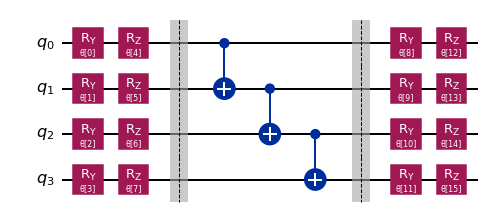

In [27]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(num_qubits=qubit_op_parity.num_qubits, reps=1, entanglement='linear', insert_barriers=True)
ansatz.decompose().draw('mpl', style='iqx')

The reason for constructing an Ansatz manually is two-fold:
1. To show you how this is done, too.
2. Writing a custom Factory for constructing a `VQEProgram` causes unnecessary overhead for this tutorial.

Now we can load our IBMQ account, the provider and select a backend which has runtime-support:

In [28]:
from qiskit import IBMQ

IBMQ.load_account()

provider = IBMQ.get_provider(group="open")
print("Provider supports runtime: ", provider.has_service("runtime"))

backend = provider.get_backend("ibmq_qasm_simulator")

Provider supports runtime:  True


And finally we can construct a new VQE solver using `VQEProgram`:

> Note: `VQEProgram` will be renamed to `VQEClient` in Qiskit Nature v0.3.0!

In [29]:
from qiskit_nature.runtime import VQEProgram

optimizer = {
    "name": "SPSA",
    "maxiter": 50,
}
initial_point = np.random.random(ansatz.num_parameters)
        
runtime_vqe = VQEProgram(
    ansatz=ansatz,
    optimizer=optimizer,
    initial_point=initial_point,
    provider=provider,
    backend=backend,
    shots=1024,
    measurement_error_mitigation=True,
)

In [30]:
runtime_vqe_solver = GroundStateEigensolver(parity_converter, runtime_vqe)

In [31]:
runtime_result = runtime_vqe_solver.solve(problem_reduced)

In [32]:
print(runtime_result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -83.630664318455
  - computed part:      -1.046528384768
  - ActiveSpaceTransformer extracted energy part: -82.584135933688
~ Nuclear repulsion energy (Hartree): 9.285714221678
> Total ground state energy (Hartree): -74.344950096778
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.711 S: 0.505 S^2: 0.760 M: -0.305
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  0.00377945]
 
  0: 
  * Electronic dipole moment (a.u.): [0.03962152  0.90352843  -0.59937014]
    - computed part:      [0.03962152  0.90352843  -0.84996171]
    - ActiveSpaceTransformer extracted energy part: [0.0  0.0  0.25059156]
  > Dipole moment (a.u.): [-0.03962152  -0.90352843  0.60314959]  Total: 1.0870708
                 (debye): [-0.10070784  -2.29653999  1.5330532]  Total: 2.76305811
 


In [33]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright